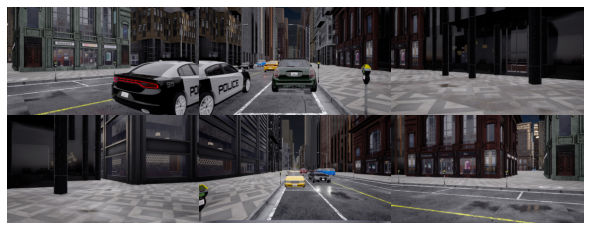

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ITEM = "0004"
SET = "routes_training_new_test"
ROUTE = "route_single_routes_training_single_date_06_26_12_54_52"

CALIB = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/calib/{ITEM}.txt"
LABEL_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/labels/{ITEM}.txt"
PCD_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/points/{ITEM}.bin" 
CAM_FRONT_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/CAM_FRONT/{ITEM}.jpg" 
CAM_FRONT_LEFT_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/CAM_FRONT_LEFT/{ITEM}.jpg"
CAM_FRONT_RIGHT_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/CAM_FRONT_RIGHT/{ITEM}.jpg"
CAM_BACK_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/CAM_BACK/{ITEM}.jpg"
CAM_BACK_LEFT_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/CAM_BACK_LEFT/{ITEM}.jpg"
CAM_BACK_RIGHT_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/CAM_BACK_RIGHT/{ITEM}.jpg"
SEMANTIC_LIDAR_PATH = f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/lidar_semantic/{ITEM}.laz"

RADAR_FILES = [
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_FRONT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_FRONT_LEFT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_FRONT_RIGHT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_BACK_LEFT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_BACK_RIGHT/{ITEM}.bin",
]

# do a 2x3 mosaic with the 6 cameras, in the order: CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
fig = plt.figure(figsize=(8, 3))
cam_front_left = plt.imread(CAM_FRONT_LEFT_PATH)
cam_front = plt.imread(CAM_FRONT_PATH)
cam_front_right = plt.imread(CAM_FRONT_RIGHT_PATH)
cam_back_left = plt.imread(CAM_BACK_LEFT_PATH)
cam_back = plt.imread(CAM_BACK_PATH)
cam_back_right = plt.imread(CAM_BACK_RIGHT_PATH)
plt.subplot(2, 3, 1)
plt.imshow(cam_front_left)
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(cam_front)
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(cam_front_right)
plt.axis('off')
plt.subplot(2, 3, 6)    
plt.imshow(cam_back_left)
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(cam_back)
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(cam_back_right)
plt.axis('off')
# Eliminar espacios entre subplots
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.savefig(f"{ITEM}_cameras_mosaic.png", bbox_inches='tight', dpi=300)
plt.show()

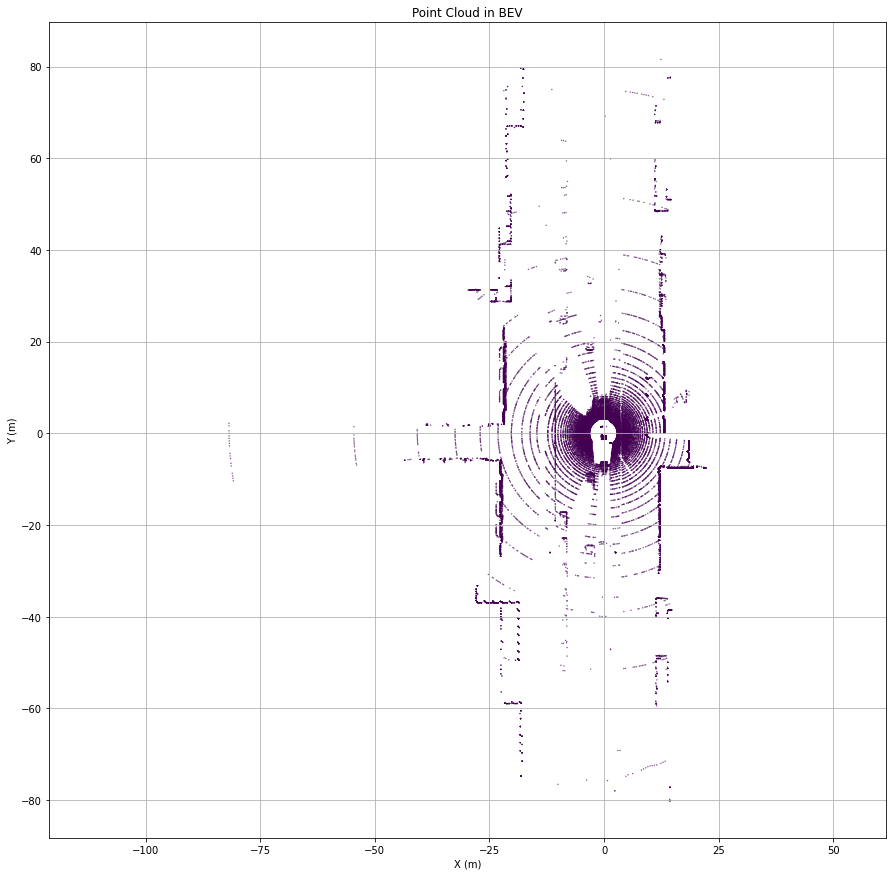

In [2]:
# plot the pcd in bev
pcd = np.fromfile(PCD_PATH, dtype=np.float32).reshape(-1, 4)
plt.figure(figsize=(15, 15))
plt.scatter(pcd[:, 0], pcd[:, 1], c=pcd[:, 3], s=0.1, cmap='viridis')
plt.axis('equal')
plt.title('Point Cloud in BEV')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.savefig(f"{ITEM}_pcd_bev.png", bbox_inches='tight', dpi=300)
plt.show()

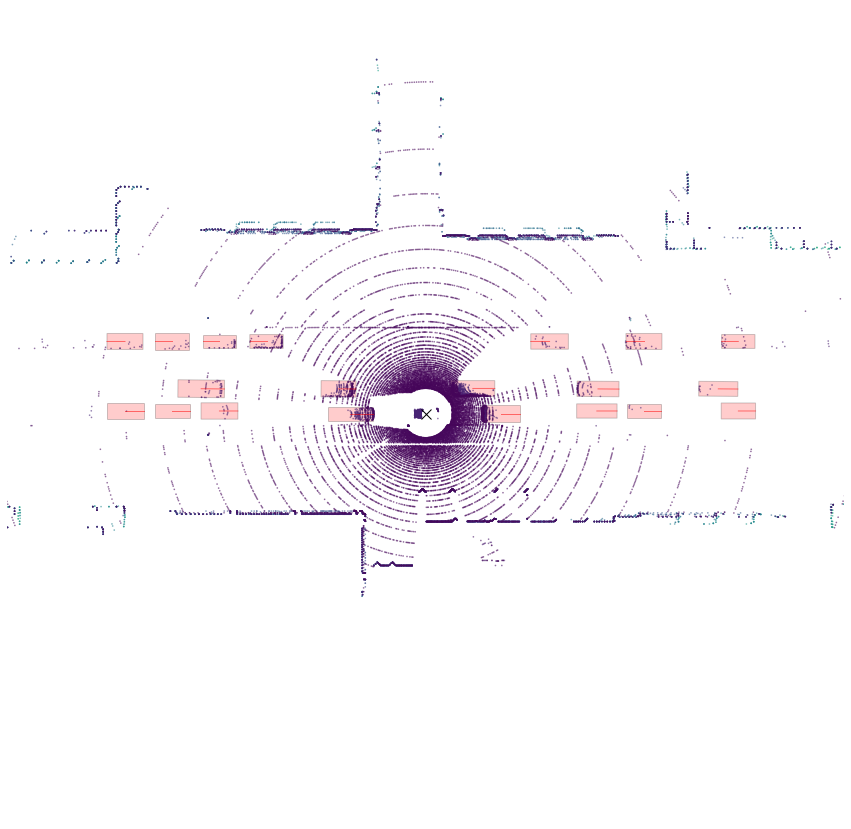

In [3]:
# load calib
calib = {}
with open(CALIB, 'r') as f:
    for line in f.readlines():
        key, value = line.strip().split(':', 1)
        calib[key] = np.array(value.split(), dtype=np.float32).reshape(4, 4)

# load labels
labels = []
with open(LABEL_PATH, 'r') as f:
    for line in f.readlines():
        labels.append(line.strip().split())

# plot labels in bev
plt.figure(figsize=(15, 15))

# draw an X in the center (ego vehicle)
plt.plot(0, 0, 'kx', markersize=10, label='Ego Vehicle')

for label in labels:
    if label[0] == 'car':
        color = 'red'
    elif label[0] == 'walker':
        color = 'blue'
    elif label[0] == 'cyclist':
        color = 'green'
    else:
        continue  # Skip unknown classes

    x = float(label[4])
    y = -float(label[5])
    z = float(label[6])  # z is not used in BEV
    w = float(label[1])
    h = float(label[2]) # h is not used in BEV
    l = float(label[3])
    rot = -float(label[7])  # rotation around the z-axis
    # Calculate the corners of the bounding box
    corners = np.array([
        [-l/2, -w/2, 0],
        [l/2, -w/2, 0],
        [l/2, w/2, 0],
        [-l/2, w/2, 0]
    ])
    # Rotate the corners
    rotation_matrix = np.array([
        [np.cos(rot), -np.sin(rot), 0],
        [np.sin(rot), np.cos(rot), 0],
        [0, 0, 1]
    ])
    corners = np.dot(corners, rotation_matrix.T)
    # Translate the corners to the object's position
    corners += np.array([x, y, z])
    # Plot the bounding box

    # draw a line for the orientation of each label
    plt.plot([x, x + np.cos(rot) * l / 2], [y, y + np.sin(rot) * l / 2], color=color, linewidth=1, alpha=0.5)

    plt.fill(corners[:, 0], corners[:, 1], color=color, alpha=0.2, edgecolor='black')
    # plt.text(x, y, label[0], color='black', fontsize=8, ha='center', va='center')

# convert pcd to egoframe using calib['LIDAR2EGO']
pcd_ego = np.dot(calib['LIDAR2EGO'][:3, :3], pcd[:, :3].T).T + calib['LIDAR2EGO'][:3, 3]
plt.scatter(pcd_ego[:, 0], pcd_ego[:, 1], c=pcd_ego[:, 2], s=0.5, cmap='viridis', alpha=0.5)
plt.axis('off')
# plt.title('Labels in BEV')
# plt.xlabel('X (m)')
# plt.ylabel('Y (m)')
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.grid(True)
plt.savefig(f"{ITEM}_labels_bev.png", bbox_inches='tight', dpi=300)
plt.show()

Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_FRONT/0004.bin
length of radar points: 4959
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_FRONT_LEFT/0004.bin
length of radar points: 4341
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_FRONT_RIGHT/0004.bin
length of radar points: 5001
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_BACK_LEFT/0004.bin
length of radar points: 4564
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_BACK_RIGHT/0004.bin
length of radar points: 4491


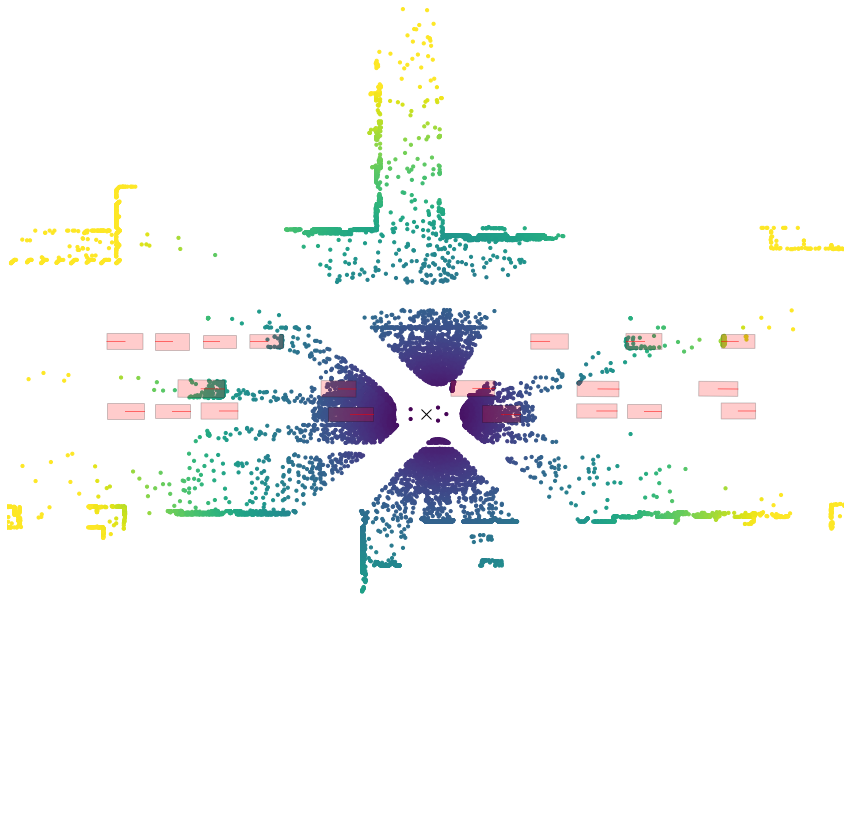

In [15]:
# RADAR PCDS
radar_matrices = [
    calib['LIDAR2RADAR_FRONT'],
    calib['LIDAR2RADAR_FRONT_LEFT'],
    calib['LIDAR2RADAR_FRONT_RIGHT'],
    calib['LIDAR2RADAR_BACK_LEFT'],
    calib['LIDAR2RADAR_BACK_RIGHT']
]

plt.figure(figsize=(15, 15))

# plt.scatter(pcd_ego[:, 0], pcd_ego[:, 1], s=1, c='black', alpha=0.5, label='Lidar Points')

for i, radar_file in enumerate(RADAR_FILES):
    print(f"Processing radar file: {radar_file}")
    # open bin file
    pcd = np.fromfile(radar_file, dtype=np.float32)
    pcd = pcd.reshape(-1, 4)

    # following data are given in radians
    range = pcd[:, 0]
    altitude = pcd[:, 1]
    azimuth = pcd[:, 2]  # this is in meters
    velocity = pcd[:, 3]  # this is in m/s

    # convert to x, y, z
    x = range * np.cos(azimuth) * np.cos(altitude)  # altitude is in radians, convert to meters
    y = -range * np.sin(azimuth) * np.cos(altitude)  # Y comes inverted
    z = range * np.sin(altitude)  # altitude is already in meters

    # add a point to 0, 0 to know radar center
    x = np.append(x, 0)
    y = np.append(y, 0)
    z = np.append(z, 0)
    velocity = np.append(velocity, 0)  # add a velocity of 0 for the center point
    range = np.append(range, 0)  # add a range of 0 for the center point

    # points are in radar frame, move them to ego frame using LIDAR2RADAR_FRONT and LIDAR2EGO
    pcd_homogeneous = np.hstack((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis], np.ones((x.shape[0], 1))))
    # pcd_ego = pcd_homogeneous @ radar_matrices[i].T @ LIDAR2EGO.T

    RADAR2EGO = calib['LIDAR2EGO'] @ np.linalg.inv(radar_matrices[i])
    pcd_radar_ego = pcd_homogeneous @ RADAR2EGO.T

    print(f"length of radar points: {len(pcd_radar_ego)}")

    x = pcd_radar_ego[:, 0]
    y = pcd_radar_ego[:, 1]  # Y COMES INVERTED

    # put one color for each of the 5 radars
    # color = ['red', 'blue', 'green', 'orange', 'purple'][i]

    plt.scatter(x, y, c=range, s=10, label=os.path.basename(radar_file), vmax=40, vmin=0)  # Coloreado por velocidad

    # sc = plt.scatter(x, y, c=velocity, cmap='coolwarm', s=10, label=os.path.basename(radar_file))  # Coloreado por velocidad
    
# draw an X in the center (ego vehicle)
plt.plot(0, 0, 'kx', markersize=10, label='Ego Vehicle')

for label in labels:
    if label[0] == 'car':
        color = 'red'
    elif label[0] == 'walker':
        color = 'blue'
    elif label[0] == 'cyclist':
        color = 'green'
    else:
        continue  # Skip unknown classes

    x = float(label[4])
    y = -float(label[5])
    z = float(label[6])  # z is not used in BEV
    w = float(label[1])
    h = float(label[2]) # h is not used in BEV
    l = float(label[3])
    rot = -float(label[7])  # rotation around the z-axis
    # Calculate the corners of the bounding box
    corners = np.array([
        [-l/2, -w/2, 0],
        [l/2, -w/2, 0],
        [l/2, w/2, 0],
        [-l/2, w/2, 0]
    ])
    # Rotate the corners
    rotation_matrix = np.array([
        [np.cos(rot), -np.sin(rot), 0],
        [np.sin(rot), np.cos(rot), 0],
        [0, 0, 1]
    ])
    corners = np.dot(corners, rotation_matrix.T)
    # Translate the corners to the object's position
    corners += np.array([x, y, z])
    # Plot the bounding box

    # draw a line for the orientation of each label
    plt.plot([x, x + np.cos(rot) * l / 2], [y, y + np.sin(rot) * l / 2], color=color, linewidth=1, alpha=0.5)

    plt.fill(corners[:, 0], corners[:, 1], color=color, alpha=0.2, edgecolor='black')
    # plt.text(x, y, label[0], color='black', fontsize=8, ha='center', va='center')

# plt.colorbar(sc, label='Velocity (m/s)')

# i want to add lines that mark the hfov of each radar. This is 15º to each side of the center of the bev, also up and down
# hfov = 40  # degrees
# angles = np.radians(np.array([-hfov, hfov]))
# for angle in angles:
#     # Calculate the end points of the lines
#     x_line = np.array([-20, 20]) * np.cos(angle)
#     y_line = np.array([-20, 20]) * np.sin(angle)
#     plt.plot(x_line, y_line, 'r--', linewidth=3)  # dashed line for hfov
#     plt.text(x_line[1], y_line[1], f'{np.degrees(angle):.0f}°', fontsize=10, ha='right')

# # also vertical 15º lines
# for angle in angles:
#     # Calculate the end points of the lines
#     x_line = np.array([-20, 20]) * np.cos(angle + np.pi / 2)
#     y_line = np.array([-20, 20]) * np.sin(angle + np.pi / 2)
#     plt.plot(x_line, y_line, 'r--', linewidth=3)  # dashed line for hfov
#     plt.text(x_line[1], y_line[1], f'{np.degrees(angle + np.pi / 2):.0f}°', fontsize=10, ha='right')

# show only frontal points
# frontal_points = lidar_pcd[lidar_pcd[:, 0] > 0]
# plt.xlabel('X (m)')
# plt.ylabel('Y (m)')
# plt.title('Radar and Lidar Bird’s Eye View')
plt.axis('off')
# plt.grid(False)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.savefig(f"{ITEM}_radar_lidar_bev.png", bbox_inches='tight', dpi=300)
plt.show()
# save


Loaded 31675 points from /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/lidar_semantic/0004.laz
Number of points: 31675
Unique semantic tags: [ 1  2  3  6 10 14 20 24]
Unique instance IDs: [    0 10041 10042 10043 10044 10062 10063 10064 10065 10066 10078 10079
 10080 10081 10082 10083 10084 10112 10113 10179 10180 10181 10182 10195
 10228 10229 10236 10252 10253]


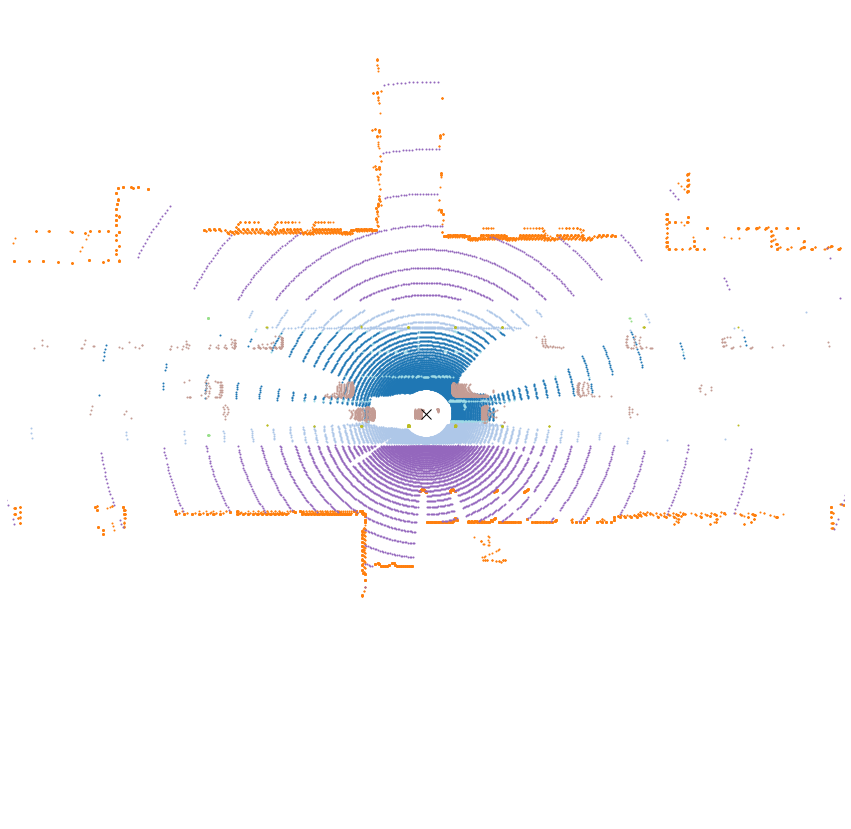

In [5]:
# Semantic Lidar

import laspy
# Load semantic lidar data
with laspy.open(SEMANTIC_LIDAR_PATH) as f:
    semantic_lidar = f.read()

print(f"Loaded {semantic_lidar.header.point_count} points from {SEMANTIC_LIDAR_PATH}")

# Extract points and colors
points = semantic_lidar.points
x = points.x
y = points.y
z = points.z
cos_alpha = points.cos_alpha
instance_id = points.instance_id
semantic_tag = points.semantic_tag

print(f"Number of points: {len(x)}")
print(f"Unique semantic tags: {np.unique(semantic_tag)}")
print(f"Unique instance IDs: {np.unique(instance_id)}")

# Plot semantic lidar points in BEV
plt.figure(figsize=(15, 15))
# invert y values

# Convert to ego frame using LIDAR2EGO
sem_pcd_homogeneous = np.hstack((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis], np.ones((x.shape[0], 1))))
sem_pcd_ego = np.dot(calib['LIDAR2EGO'][:3, :3], sem_pcd_homogeneous[:, :3].T).T + calib['LIDAR2EGO'][:3, 3]
x_ego = sem_pcd_ego[:, 0]
y_ego = sem_pcd_ego[:, 1] 
# Plot points with color based on semantic tag
colors = plt.cm.get_cmap('tab20', np.max(semantic_tag) + 1)
for tag in np.unique(semantic_tag):
    mask = semantic_tag == tag
    plt.scatter(x_ego[mask], y_ego[mask], c=[colors(tag)], s=1, label=f'Semantic Tag {tag}')
# draw an X in the center (ego vehicle)
plt.plot(0, 0, 'kx', markersize=10, label='Ego Vehicle')
# Add labels and legend
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
# plt.title('Semantic Lidar Points in BEV')
plt.xlim(-50, 50)
plt.ylim(-50, 50)   
plt.axis('off')
plt.grid(True)
plt.savefig(f"{ITEM}_semantic_lidar_bev.png", bbox_inches='tight', dpi=300)
plt.show()

# PLOT PCD IN CAMERAS

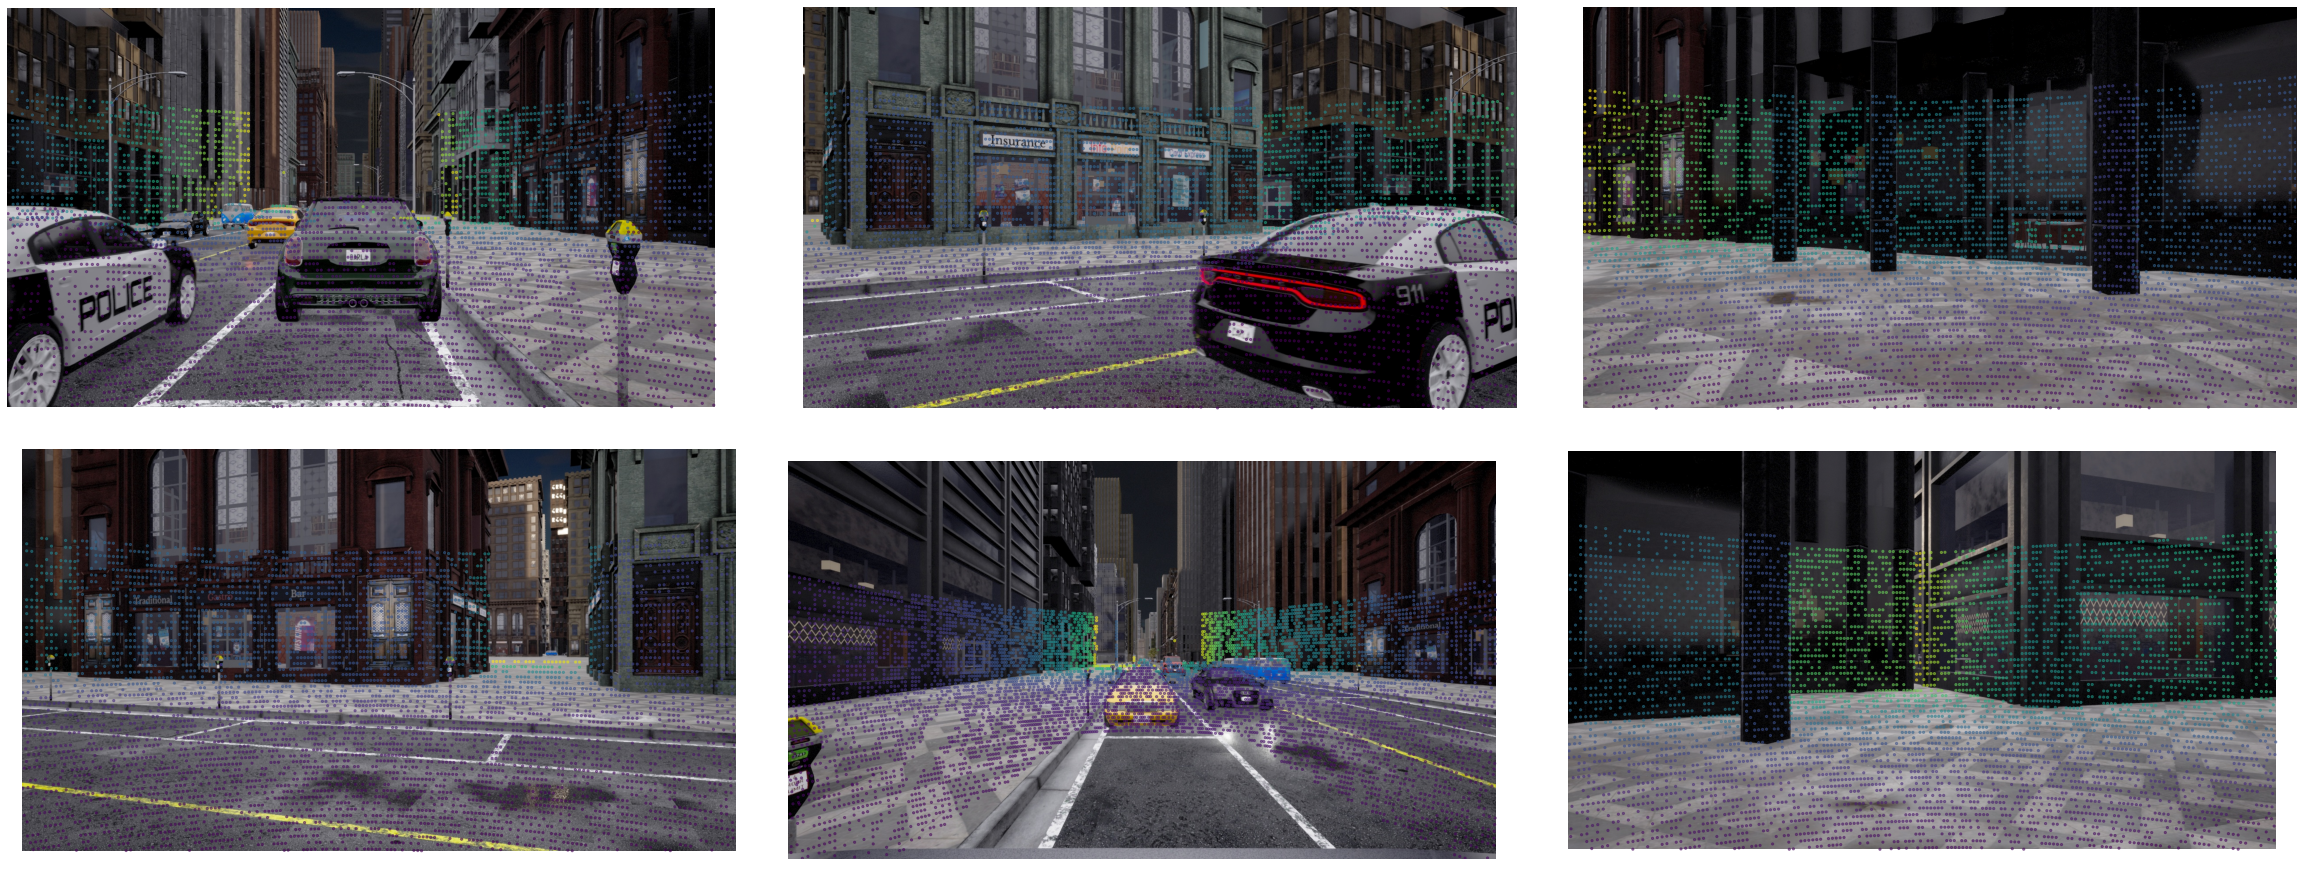

In [6]:
# i want to project the pcd onto every camera in a single figure
CAMERAS_DICT = {
    "CAM_FRONT": CAM_FRONT_PATH,
    "CAM_FRONT_LEFT": CAM_FRONT_LEFT_PATH,
    "CAM_FRONT_RIGHT": CAM_FRONT_RIGHT_PATH,
    "CAM_BACK_LEFT": CAM_BACK_LEFT_PATH,
    "CAM_BACK": CAM_BACK_PATH,
    "CAM_BACK_RIGHT": CAM_BACK_RIGHT_PATH
}

pcd = np.fromfile(PCD_PATH, dtype=np.float32).reshape(-1, 4)
pcd_homogeneous = np.hstack((pcd[:, :3], np.ones((pcd.shape[0], 1))))

# Crear figura
fig = plt.figure(figsize=(32, 12))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)

for i, (key, value) in enumerate(CAMERAS_DICT.items()):
    ax = fig.add_subplot(2, 3, i + 1)
    img = mpimg.imread(value)

    ax.imshow(img)
    ax.axis('off')

    # Obtener matrices de calibración
    cam_K = calib[f'{key}_K']
    lidar2cam = calib[f'LIDAR2{key}']

    # Proyección de puntos
    pcd_cam = np.dot(lidar2cam, pcd_homogeneous.T).T
    pcd_cam = pcd_cam[pcd_cam[:, 2] > 0]  # Mantener solo puntos delante de la cámara
    pcd_img = np.dot(cam_K, pcd_cam.T).T
    pcd_img[:, 0] /= pcd_img[:, 2]
    pcd_img[:, 1] /= pcd_img[:, 2]

    # Filtrar puntos dentro de la imagen
    mask = (
        (pcd_img[:, 0] >= 0) & (pcd_img[:, 0] < img.shape[1]) &
        (pcd_img[:, 1] >= 0) & (pcd_img[:, 1] < img.shape[0])
    )
    pcd_img = pcd_img[mask]
    depth = pcd_cam[mask, 2]  # Usar profundidad real como color

    # Representar los puntos
    ax.scatter(pcd_img[:, 0], pcd_img[:, 1], c=depth, s=5, cmap='viridis', alpha=0.5)

# plt.savefig(f"{ITEM}_pcd_projected_on_cameras.png", bbox_inches='tight', dpi=300)
# Plot the point cloud projected onto each camera image
plt.show()

# PLOT RADAR PCD IN CAMERAS

Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_FRONT/0004.bin
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_FRONT_LEFT/0004.bin
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_FRONT_RIGHT/0004.bin
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_BACK_LEFT/0004.bin
Processing radar file: /home/nupdm/Datasets/nuPDM/routes_training_new_test/route_single_routes_training_single_date_06_26_12_54_52/RADAR_BACK_RIGHT/0004.bin
Total number of radar points: 23351


IndexError: boolean index did not match indexed array along dimension 0; dimension is 23351 but corresponding boolean dimension is 10700

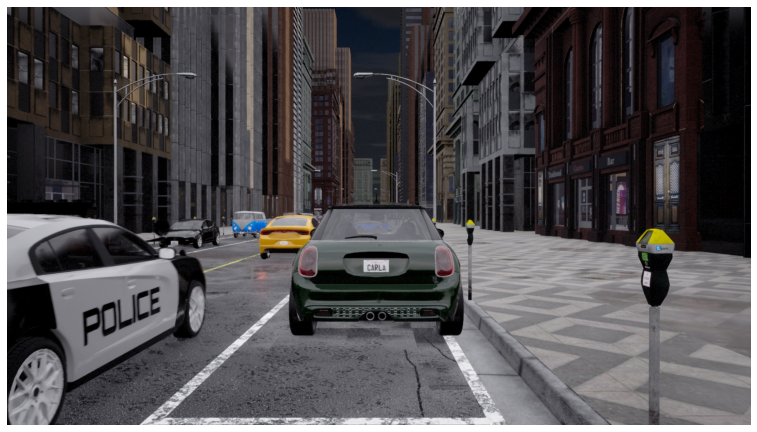

In [17]:
# i want to project the pcd onto every camera in a single figure
RADAR_FILES = [
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_FRONT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_FRONT_LEFT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_FRONT_RIGHT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_BACK_LEFT/{ITEM}.bin",
    f"/home/nupdm/Datasets/nuPDM/{SET}/{ROUTE}/RADAR_BACK_RIGHT/{ITEM}.bin",
]

RADAR_MATRICES = [
    calib['LIDAR2EGO'] @ np.linalg.inv(calib['LIDAR2RADAR_FRONT']),
    calib['LIDAR2EGO'] @ np.linalg.inv(calib['LIDAR2RADAR_FRONT_LEFT']),
    calib['LIDAR2EGO'] @ np.linalg.inv(calib['LIDAR2RADAR_FRONT_RIGHT']),
    calib['LIDAR2EGO'] @ np.linalg.inv(calib['LIDAR2RADAR_BACK_LEFT']),
    calib['LIDAR2EGO'] @ np.linalg.inv(calib['LIDAR2RADAR_BACK_RIGHT']) 
]

# load the 5 radars and group them in a single point cloud, after converting them to ego
for i, radar_file in enumerate(RADAR_FILES):
    print(f"Processing radar file: {radar_file}")
    # open bin file
    pcd = np.fromfile(radar_file, dtype=np.float32)
    pcd = pcd.reshape(-1, 4)
    # following data are given in radians
    range = pcd[:, 0]
    altitude = pcd[:, 1]
    azimuth = pcd[:, 2]  # this is in meters
    velocity = pcd[:, 3]  # this is in m/s
    # convert to x, y, z
    x = range * np.cos(azimuth) * np.cos(altitude)  # altitude is in radians, convert to meters
    y = -range * np.sin(azimuth) * np.cos(altitude)  # Y comes inverted
    z = range * np.sin(altitude)  # altitude is already in meters

    # ego radar pcd
    pcd_homogeneous = np.hstack((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis], np.ones((x.shape[0], 1))))
    pcd_ego = pcd_homogeneous @ RADAR_MATRICES[i].T
    x = pcd_ego[:, 0]
    y = pcd_ego[:, 1]  
    z = pcd_ego[:, 2]

    # create a single point cloud with all radars
    if i == 0:
        radar_pcd = np.array([x, y, z, velocity]).T
    else:
        radar_pcd = np.vstack((radar_pcd, np.array([x, y, z, velocity]).T))

print(f"Total number of radar points: {len(radar_pcd)}")

# Crear figura
fig = plt.figure(figsize=(32, 12))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)

# Convertir el radar PCD a homogéneo
radar_pcd_homogeneous = np.hstack((radar_pcd[:, :3], np.ones((radar_pcd.shape[0], 1))))
velocities = radar_pcd[:, 3]  # Extraer velocidades

for i, (key, value) in enumerate(CAMERAS_DICT.items()):
    ax = fig.add_subplot(2, 3, i + 1)
    img = mpimg.imread(value)

    ax.imshow(img)
    ax.axis('off')

    # Obtener matrices de calibración
    cam_K = calib[f'{key}_K']
    lidar2cam = calib[f'LIDAR2{key}']
    ego2cam = lidar2cam @ np.linalg.inv(calib['LIDAR2EGO'])

    # Proyección de puntos
    radar_pcd_cam = np.dot(ego2cam, radar_pcd_homogeneous.T).T

    mask = (radar_pcd_cam[:, 2] > 0)  # Mantener solo puntos delante de la cámara
    radar_pcd_cam = radar_pcd_cam[mask]  # Filtrar puntos delante de la cámara
    velocities = velocities[mask]  # Filtrar velocidades según la máscara

    pcd_img = np.dot(cam_K, radar_pcd_cam.T).T
    pcd_img[:, 0] /= pcd_img[:, 2]
    pcd_img[:, 1] /= pcd_img[:, 2]

    # Filtrar puntos dentro de la imagen
    mask = (
        (pcd_img[:, 0] >= 0) & (pcd_img[:, 0] < img.shape[1]) &
        (pcd_img[:, 1] >= 0) & (pcd_img[:, 1] < img.shape[0])
    )
    pcd_img = pcd_img[mask]
    depth = radar_pcd_cam[mask, 2]  # Usar profundidad real como color

    velocities = velocities[mask]  # Filtrar velocidades según la máscara

    # Representar los puntos
    ax.scatter(pcd_img[:, 0], pcd_img[:, 1], c=velocity, s=20, cmap='viridis', alpha=1)

# plt.savefig(f"{ITEM}_pcd_projected_on_cameras.png", bbox_inches='tight', dpi=300)
# Plot the point cloud projected onto each camera image
plt.show()

# PLOT SEM PCD IN CAMERAS

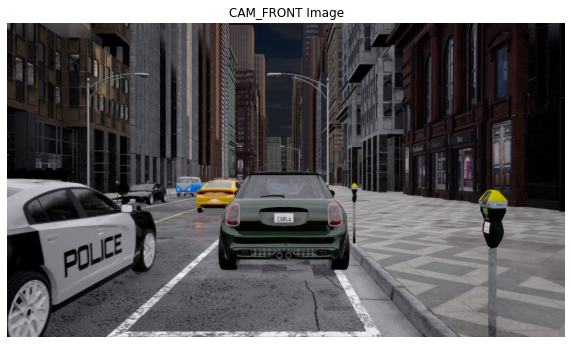

In [8]:
cam_front = mpimg.imread(CAM_FRONT_PATH)
plt.figure(figsize=(10, 10))
plt.imshow(cam_front)
plt.axis('off')
plt.title('CAM_FRONT Image')

sem_pcd_homogeneous = np.hstack((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis], np.ones((x.shape[0], 1))))

# project pcd to image

lidar2cam_front = calib['LIDAR2CAM_FRONT']
sem_pcd_data_front = np.dot(lidar2cam_front, sem_pcd_homogeneous.T).T
sem_pcd_data_front = sem_pcd_data_front[sem_pcd_data_front[:, 2] > 0]  # Filter out points behind the camera
sem_pcd_data_front = np.dot(calib["CAM_FRONT_K"], sem_pcd_data_front.T).T
sem_pcd_data_front[:,0] /= sem_pcd_data_front[:,2]
sem_pcd_data_front[:,1] /= sem_pcd_data_front[:,2]

# Filter points within image bounds
sem_pcd_data_front = sem_pcd_data_front[
    (sem_pcd_data_front[:, 0] >= 0) & (sem_pcd_data_front[:, 0] < 1600) &
    (sem_pcd_data_front[:, 1] >= 0) & (sem_pcd_data_front[:, 1] < 900)
]

# Draw points on camera
plt.scatter(sem_pcd_data_front[:, 0], sem_pcd_data_front[:, 1], c='red', s=1, label='Lidar Points')
# plt.legend()
# plt.savefig(f"{ITEM}_sem_lidar_cam_front.png", bbox_inches='tight', dpi=300)
plt.show()
